## POints

In [0]:
import requests

In [0]:
headers = {
    'accept': 'application/json, text/javascript, */*; q=0.01',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'ru,en;q=0.9,el;q=0.8',
    'content-length': '21',
    'content-type': 'application/x-www-form-urlencoded; charset=UTF-8',
    'cookie': '_ga=GA1.2.1432895362.1569567665; _gid=GA1.2.1476036415.1569567665; 469838ec60a6378c83773a23bb93b954=9f01d2209e72e550c8454c993f6f2bbf; _gcl_au=1.1.65746254.1569570286',
    'dnt': '1',
    'origin': 'https://recyclemap.ru',
    'user-agent': 'Mozilla/5.0 (X11; CrOS x86_64 10323.67.9) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.209 Safari/537.36',
    'x-requested-with': 'XMLHttpRequest'
}

In [0]:
IZH = 53
KAZ = 20
MSK = 1
r = requests.post('https://recyclemap.ru/index.php?option=com_greenmarkers&task=get_json&type=points&tmpl=component', 
                          {'city': KAZ, 'layer': 0, 'gos': 0},
                          headers=headers)

In [0]:
for id_, point in r.json().items():
    assert 'address' in point, id_
    assert 'cats' in point, id_
    assert 'content_text' in point, id_
    assert 'lat' in point, id_
    assert 'lng' in point, id_
    assert 'reiting' in point, id_
    assert 'title' in point, id_

In [0]:
r.json()['1146']

{'address': 'Проспект Победы, 91',
 'cats': '5',
 'content': '<div class="trash_type sm_trash_type"><span style="background-image: url(images/trash/trash5.png)" data-tooltip=""></span></div>',
 'content_text': 'Одежда',
 'id': '1146',
 'lat': '55.769614',
 'lng': '49.216916',
 'reiting': '5',
 'title': 'ТЦ Южный, магазин H&M'}

In [0]:
cats_to_names = {}
for el in r.json().values():
    cats = el['cats'].split('_')
    cats_names = el['content_text'].split(', ')
    for cid, cname in zip(cats, cats_names):
        if cid in cats_to_names:
            assert cats_to_names[cid] == cname, '{} != {}'.format(cats_to_names[cid], cname)
        else:
            cats_to_names[cid] = cname

In [0]:
cats_to_names

{'1': 'Бумага',
 '10': 'Бытовая техника',
 '2': 'Стекло',
 '3': 'Пластик',
 '4': 'Металл',
 '5': 'Одежда',
 '6': 'Иное',
 '7': 'Опасные отходы',
 '8': 'Батарейки',
 '9': 'Лампочки'}

In [0]:
import json

In [0]:
with open('moscow.json', 'w') as f:
    json.dump(r.json(), f)

## Trash Classifier 

In [130]:
!git clone https://github.com/garythung/trashnet
!unzip trashnet/data/dataset-resized.zip > /dev/null

fatal: destination path 'trashnet' already exists and is not an empty directory.
replace __MACOSX/dataset-resized/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [87]:
import torch
torch.cuda.get_device_name(0)


'Tesla T4'

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

sns.set_style('darkgrid')

In [0]:
!rm -rf data/*

### Extend the dataset

In [88]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import os
DIR = '/gdrive/My Drive/Colab Notebooks/recycle'
def path(fn):
    return os.path.join(DIR, fn)

In [0]:
from PIL import Image

dest_path = path('resized')
if not os.path.exists(dest_path):
    os.makedirs(dest_path)
WIDTH = 512; HEIGHT = 384

def prepare_image(image_path):
    pic = Image.open(image_path)
    name = os.path.basename(image_path)
    w, h = pic.size
    new_h = int(max(HEIGHT, h * WIDTH/w))
    pic = pic.resize((WIDTH, new_h))
    pic = pic.crop((0, (new_h-HEIGHT)//2, WIDTH, (new_h-HEIGHT)//2 + HEIGHT))
    save_path = os.path.join(dest_path, name)
    pic.save(save_path)
    return save_path


In [135]:
len([os.remove(os.path.join(dest_path, jpg)) for jpg in os.listdir(dest_path)])

0

In [136]:
for img in tqdm(glob(path('*.jpg'))):
    new_path = prepare_image(img)
    directory, fname = os.path.split(new_path)
    num = re.search(r'[a-z]+(\d+).jpg', fname).group(1)
    newfname = fname.replace(num, '99' + num)
    shutil.move(new_path, os.path.join(directory, newfname))
os.listdir(dest_path)[:10]

100%|██████████| 125/125 [00:23<00:00,  5.93it/s]


['plastic991.jpg',
 'metal992.jpg',
 'metal991.jpg',
 'glass991.jpg',
 'plastic992.jpg',
 'paper991.jpg',
 'plastic994.jpg',
 'metal994.jpg',
 'metal995.jpg',
 'metal996.jpg']

In [137]:
classes = [d for d in os.listdir('dataset-resized') if not d.startswith('.')]
classes

['plastic', 'paper', 'trash', 'metal', 'glass', 'cardboard']

In [0]:
for res_img in glob(path('resized/*.jpg')):
    folder, file = os.path.split(res_img)
    for potential_folder in classes:
        if not file.startswith(potential_folder):
            continue
        new_path = 'dataset-resized/' + potential_folder + '/' + file
        if os.path.exists(new_path):
            raise(Exception(f'Error: {new_path} already exists'))
        shutil.copy(res_img, new_path)

In [139]:
sorted(os.listdir('dataset-resized/metal'))[-10:]

['metal9928.jpg',
 'metal9929.jpg',
 'metal993.jpg',
 'metal9930.jpg',
 'metal9931.jpg',
 'metal994.jpg',
 'metal995.jpg',
 'metal996.jpg',
 'metal997.jpg',
 'metal999.jpg']

### Split the Dataset and so on

In [0]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(n))

    ## train indices
    random.seed(seed1)
    K = 0.9 # 0.5
    train = random.sample(list(range(n)),int(K*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    source_folder = os.path.join('dataset-resized', waste_type)
    all_files = os.listdir(source_folder)
    file_names = [all_files[i] for i in indices]
    return(file_names)

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)


In [141]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)

if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))

## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder, 1, 1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    valid_names = get_names(waste_type,valid_ind)
    test_names = get_names(waste_type,test_ind)
    
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

dataset-resized/cardboard
412
[68, 291, 391, 32, 130, 60, 253, 389, 230, 241, 333, 194, 107, 48, 249, 14, 199, 221, 311, 390, 1, 356, 228, 136, 369, 117, 302, 52, 162, 15, 11, 13, 332, 277, 4, 195, 351, 110, 216, 371, 396, 270, 113, 224, 405, 283, 119, 176, 118, 346, 112, 235, 148, 381, 213, 284, 328, 51, 95, 322, 151, 61, 170, 256, 373, 259, 343, 97, 155, 145, 300, 255, 258, 201, 301, 17, 245, 124, 206, 212, 88, 187, 280, 191, 44, 368, 260, 55, 83, 266, 338, 189, 250, 382, 240, 22, 157, 314, 303, 296, 321, 87, 86, 257, 116, 6, 102, 276, 329, 363, 207, 263, 364, 295, 180, 360, 137, 313, 2, 196, 262, 66, 265, 287, 105, 218, 28, 246, 186, 305, 339, 211, 248, 182, 379, 177, 0, 169, 234, 372, 386, 90, 92, 46, 407, 16, 36, 42, 8, 231, 7, 143, 127, 298, 56, 94, 299, 74, 336, 264, 40, 65, 135, 243, 43, 168, 69, 165, 278, 75, 307, 179, 82, 362, 121, 29, 306, 79, 98, 310, 399, 203, 398, 290, 27, 64, 366, 267, 53, 345, 374, 209, 5, 57, 377, 101, 37, 9, 184, 41, 114, 297, 129, 173, 109, 139, 308,

In [142]:
path = Path(os.getcwd())/"data"
path


PosixPath('/content/data')

In [0]:
tfms = get_transforms(do_flip=True, flip_vert=True)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, bs=8)

In [0]:
data.test_ds

In [145]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


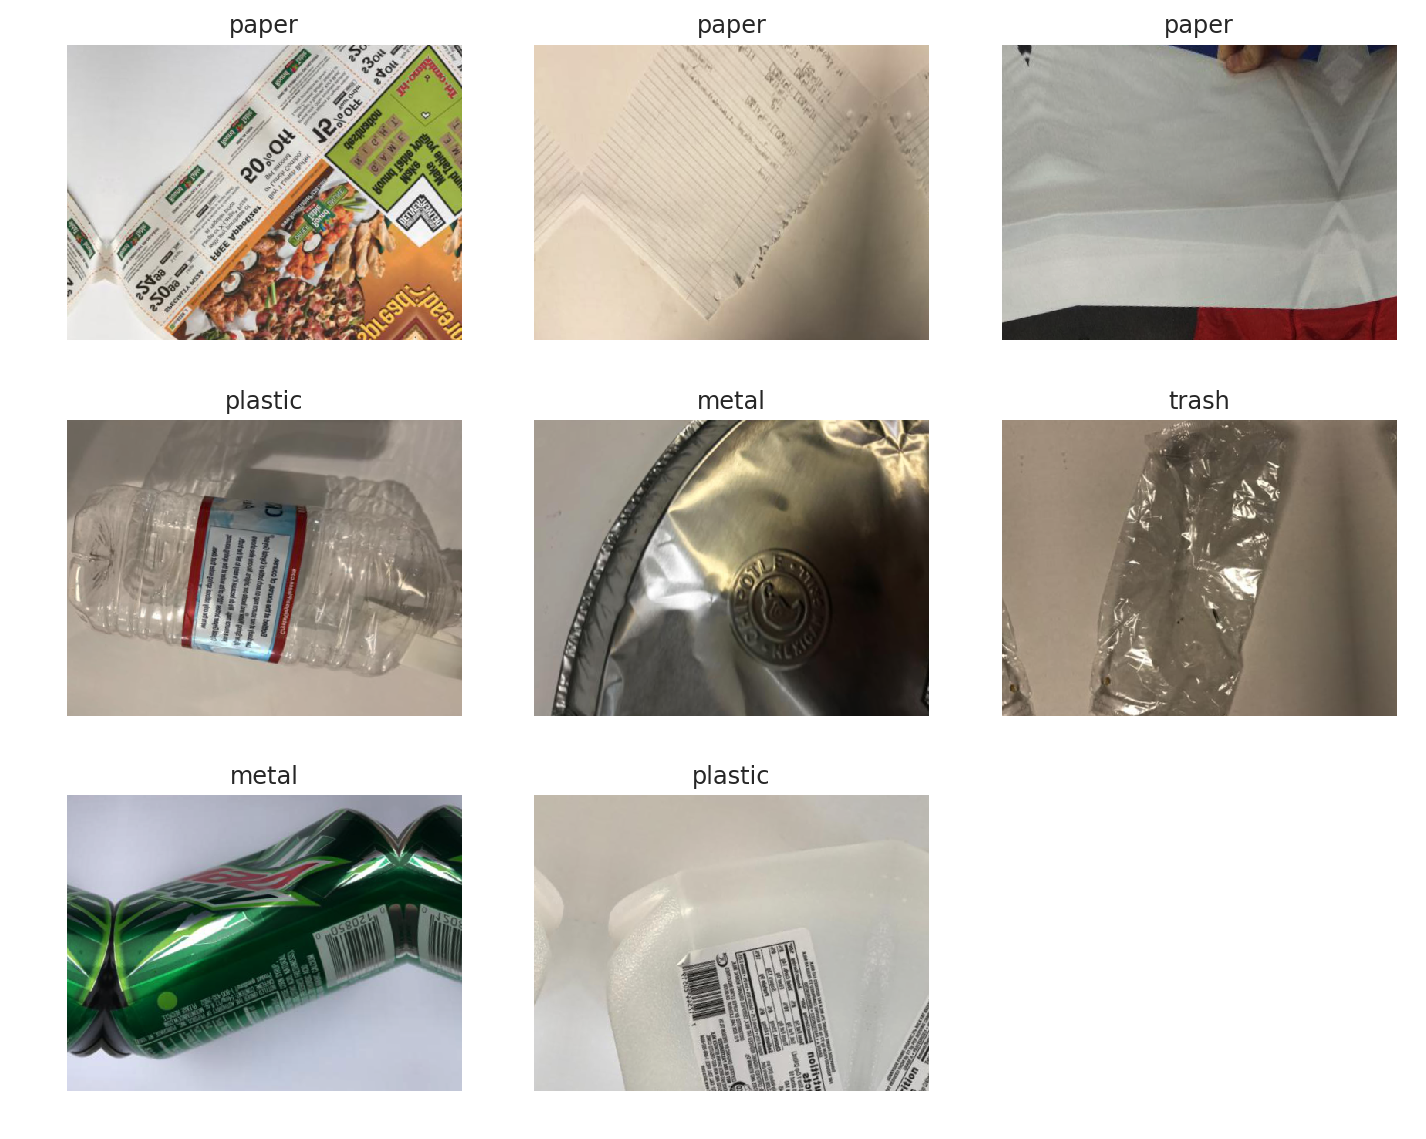

In [148]:
data.show_batch(rows=4,figsize=(10,8))

In [149]:
learn = create_cnn(data,models.resnet34,metrics=[error_rate, accuracy])

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 84879851.89it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.82E-04
Min loss divided by 10: 3.55E-03


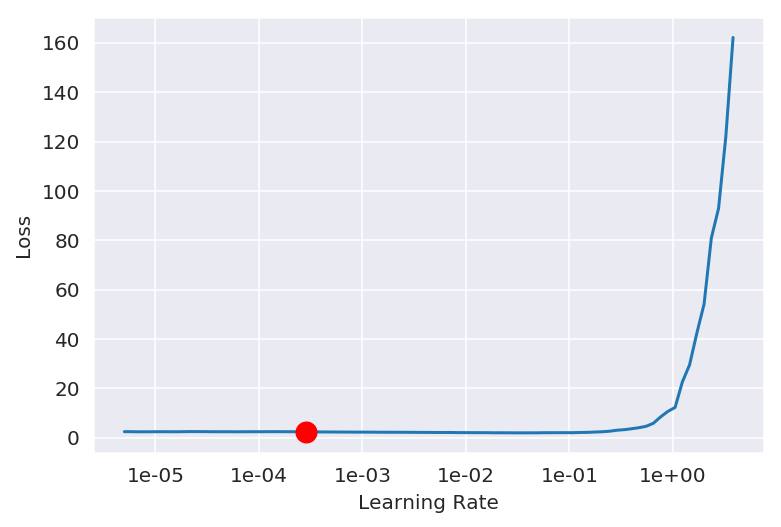

In [150]:
learn.lr_find(start_lr=1e-6, end_lr=1e1, stop_div=False)
learn.recorder.plot(suggestion=True)

In [151]:
learn.fit_one_cycle(30,max_lr=3.5E-03)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.245532,0.769058,0.243446,0.756554,01:08
1,0.864030,0.547246,0.205993,0.794007,01:09
2,0.744900,0.541087,0.172285,0.827715,01:07
3,0.778025,0.518690,0.202247,0.797753,01:10
4,0.734805,0.564809,0.198502,0.801498,01:09
5,0.747556,0.563934,0.187266,0.812734,01:07
6,0.710736,0.490928,0.183521,0.816479,01:07
7,0.690489,0.490867,0.179775,0.820225,01:06
8,0.783115,0.621827,0.217228,0.782772,01:07
9,0.760060,0.473613,0.168539,0.831461,01:06


In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()


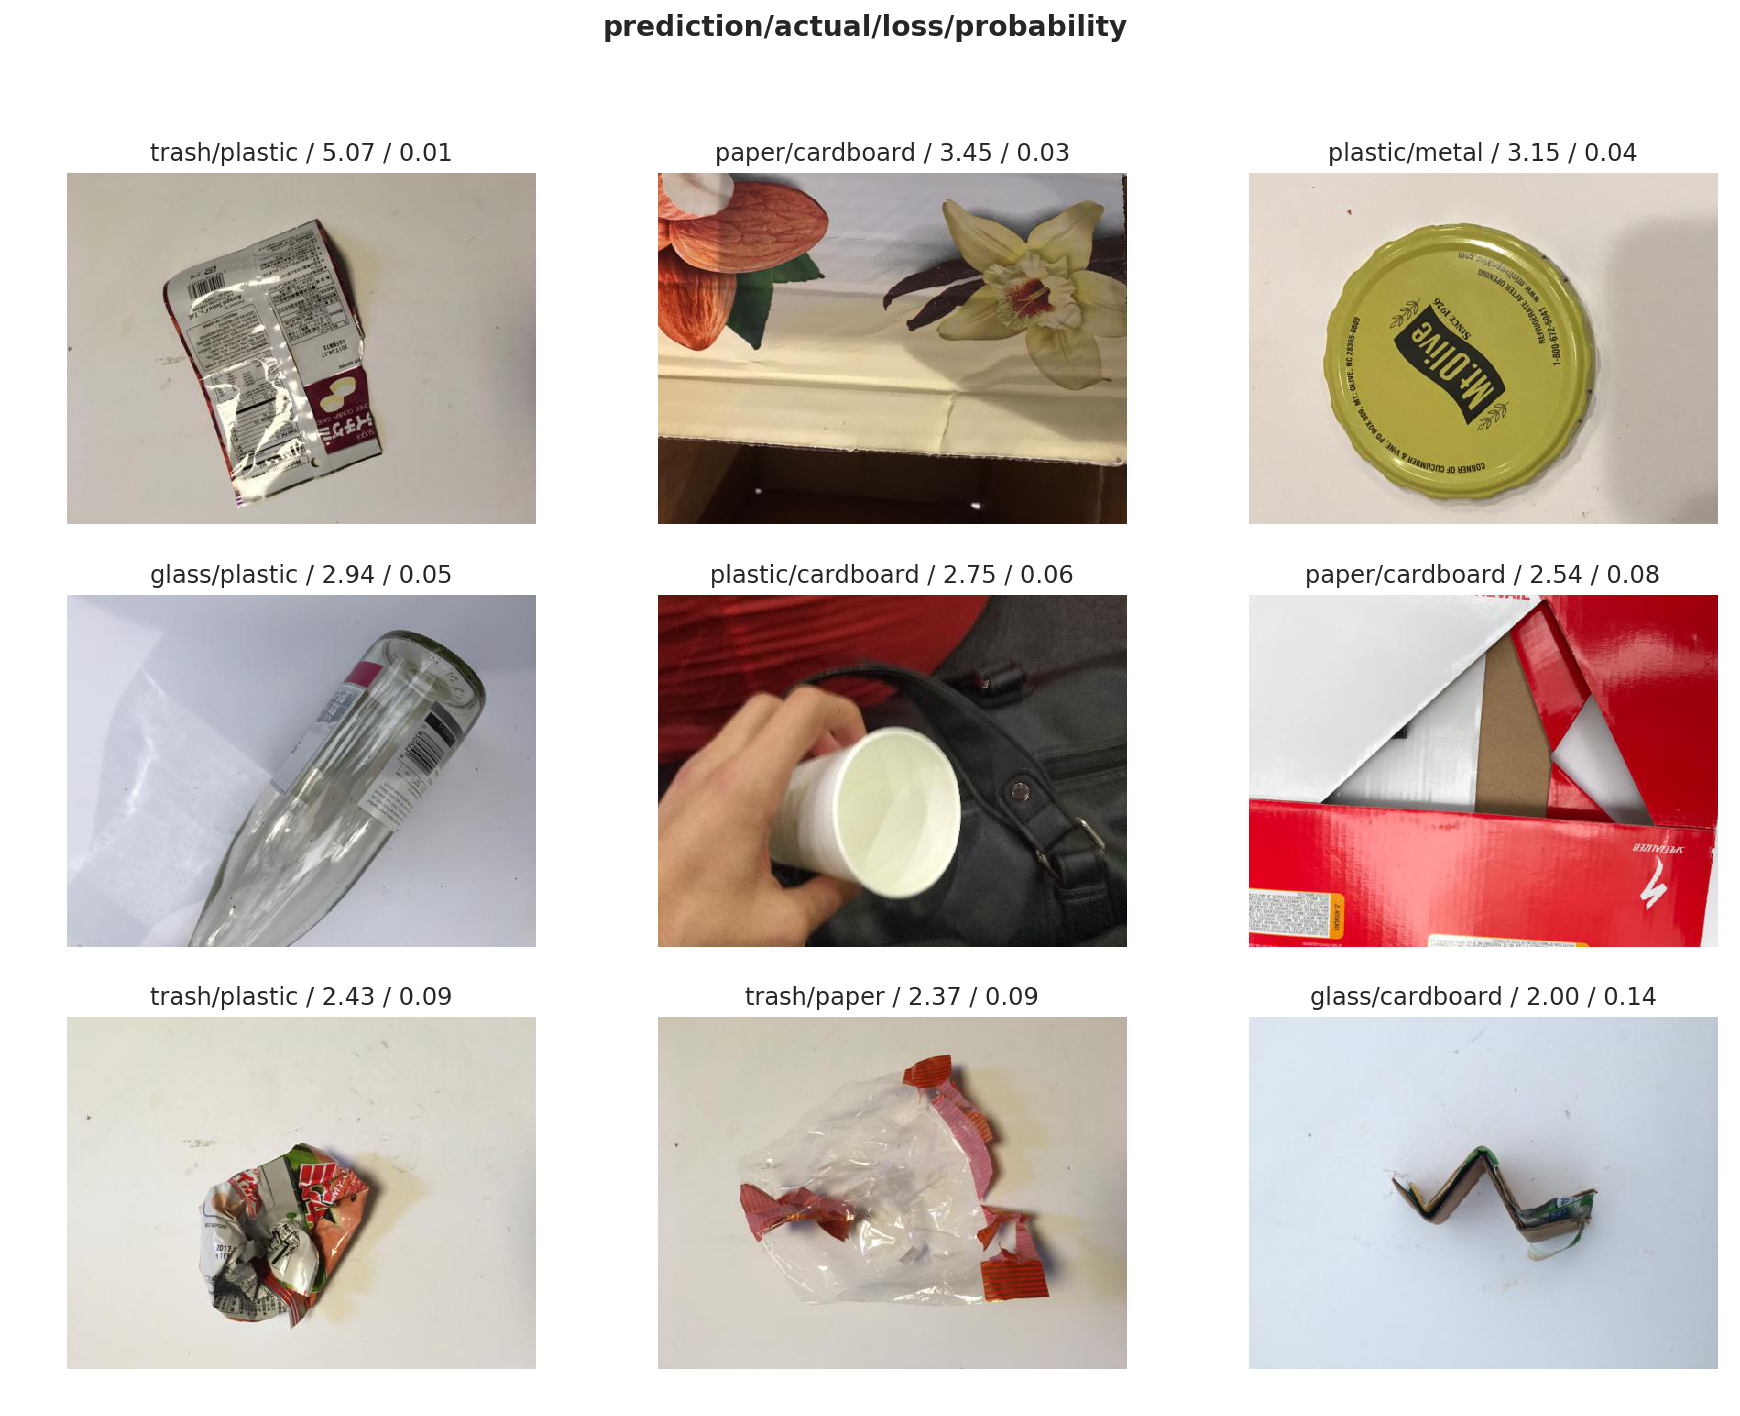

In [153]:
interp.plot_top_losses(9, figsize=(15,11))

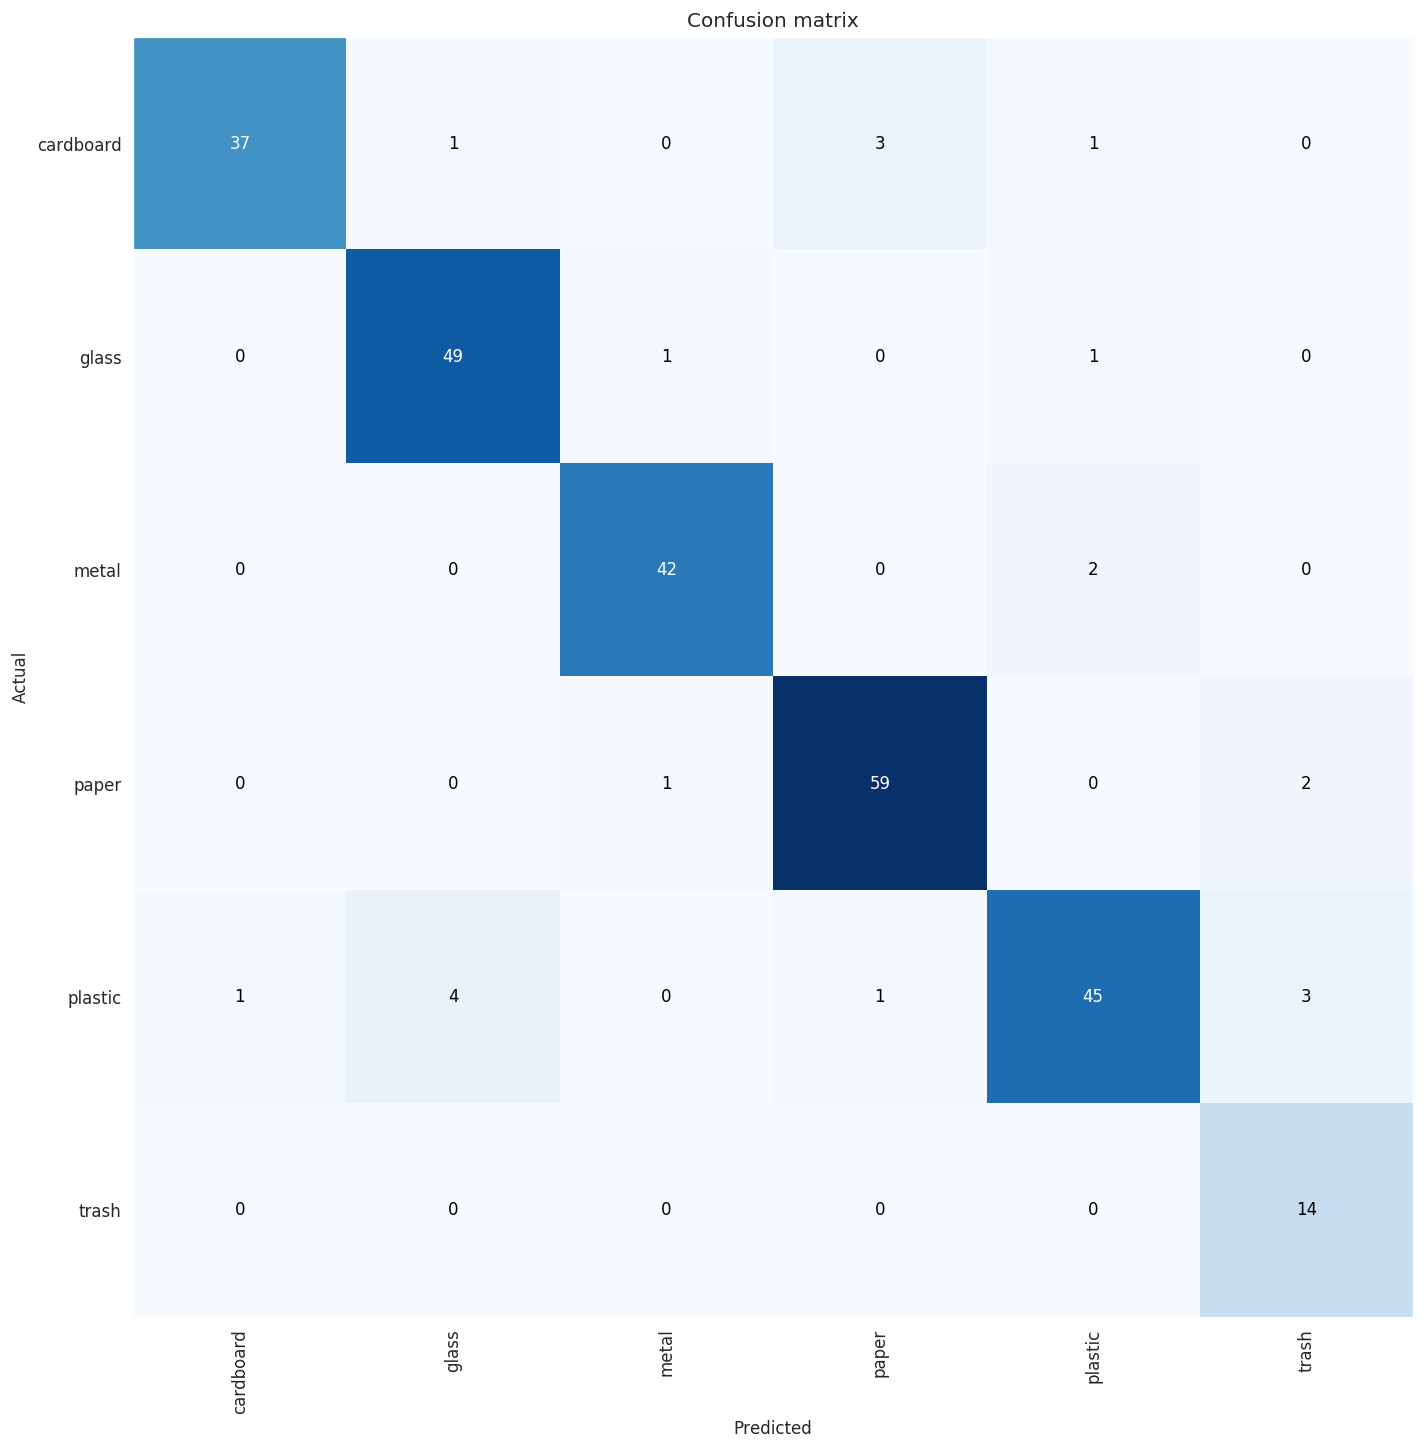

In [154]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))


In [0]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])


In [0]:
yhat[:5]

['metal', 'metal', 'cardboard', 'glass', 'plastic']

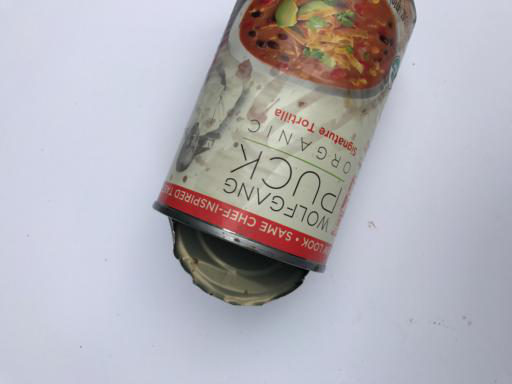

In [0]:
learn.data.test_ds[0][0]

In [0]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [0]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['metal', 'metal', 'cardboard', 'glass', 'plastic']
['metal', 'metal', 'cardboard', 'glass', 'plastic']


In [0]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 96   0   2   3   0   0]
 [  1 113   7   0   5   0]
 [  0   5  96   2   0   0]
 [  1   0   0 147   1   0]
 [  0   5   0   0 114   2]
 [  0   0   0   7   1  27]]


In [0]:
sum(pd.Series(yhat) == pd.Series(y))/len(y)

0.9338582677165355

In [0]:
learn.export(path('trashclf.pkl'))

In [0]:
learn = load_learner(path('.'), 'trashclf.pkl')

In [0]:
img = open_image('data/train/glass/glass102.jpg')

In [0]:
cpred = learn.predict(img)

In [0]:
cat = int(cpred[1])
prob = cpred[2][cat]
float(prob)

0.9560139775276184

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
DIR = '/gdrive/My Drive/Colab Notebooks/recycle'
def path(fn):
    return os.path.join(DIR, fn)

In [0]:
!pip install Pillow

In [0]:
from PIL import Image
dest_path = path('resized')
if not os.path.exists(dest_path):
    os.makedirs(dest_path)
DIM1 = 512; DIM2 = 384
file = "plastic60.jpg"
pic = Image.open(path(file))

w, h = pic.size
new_h = int(max(DIM2, h * DIM1/w))
pic = pic.resize((DIM1, new_h))
pic = pic.crop((0, (new_h-DIM2)//2, DIM1, (new_h-DIM2)//2 + DIM2))
pic.save(os.path.join(dest_path, file) )

CPU times: user 5.49 ms, sys: 879 µs, total: 6.37 ms
Wall time: 8.29 ms
torch.Size([384, 512])


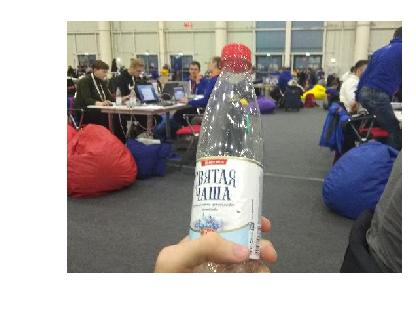

In [161]:
%time myimg = open_image(path('resized/'+file))
print(myimg.size)
myimg.show()

In [0]:
!pip show torch

Name: torch
Version: 1.1.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: UNKNOWN
Author: UNKNOWN
Author-email: UNKNOWN
License: UNKNOWN
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy
Required-by: torchvision, torchtext, fastai


In [162]:
learn.predict(myimg)

(Category plastic,
 tensor(4),
 tensor([2.4694e-02, 1.0741e-05, 5.9510e-03, 1.5758e-03, 9.6679e-01, 9.7430e-04]))

In [0]:
learn.data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

## Wiki Codes

In [0]:
import requests
from bs4 import BeautifulSoup
res = requests.get('https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%B4%D1%8B_%D0%BF%D0%B5%D1%80%D0%B5%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8')
res.status_code

200

In [0]:
soup = BeautifulSoup(res.text, 'html.parser')
for sup in soup.find_all("sup"): 
    sup.decompose()

In [0]:
c.text

'Пластмассы'

In [0]:
import os
from tqdm import tqdm

In [0]:
!rm img/*

In [0]:
def read_table(tbl):
    data = []
    for row in tqdm(tbl.select('tr')):
        cells = row.select('td')
        if not cells:
            continue
        img = cells[0].select_one('img')
        if img is None:
            continue
        image_url = 'https:' + img.attrs['src']
        if 'empty' in image_url.lower():
            continue
        img_data = requests.get(image_url).content
        image_name = os.path.basename(image_url)
        image_path = 'img/'+image_name
        if os.path.exists(image_path):
            raise image_path + ' already exists'
        with open(image_path, 'wb') as handler:
            handler.write(img_data)
        data.append({
            'img': image_name,
            'id': cells[1].text.strip(),
            'desc': cells[-2].text.strip(),
            'samples': cells[-1].text.strip()
        })
    return data

In [0]:
categories = soup.select('h3 .mw-headline')
from collections import OrderedDict
cat_results = []
for c in categories:
    tbl = c.parent.select_one('+ table')
    cat_results.append({'cat_name': c.text.strip(), 'cat_data': read_table(tbl)})

100%|██████████| 8/8 [00:01<00:00,  7.00it/s]


In [0]:
cat_results

[{'cat_data': [{'desc': 'Полиэтилентерефталат (лавсан)',
    'id': '1 PET',
    'img': '60px-Plastic-recyc-01.svg.png',
    'samples': 'Полиэстер, бутылки для напитков'},
   {'desc': 'Полиэтилен высокой плотности(низкого давления)',
    'id': '2 PEHD (также PE)(HDPE)',
    'img': '60px-Plastic-recyc-02.svg.png',
    'samples': 'Пластиковые бутылки, пакеты, мусорные вёдра'},
   {'desc': 'Поливинилхлорид',
    'id': '3 PVC',
    'img': '60px-Plastic-recyc-03.svg.png',
    'samples': 'Оконные рамы, бутылки для химических продуктов, покрытия для полов, изоляция (электротехника) электрических проводов'},
   {'desc': 'Полиэтилен низкой плотности(высокого давления)',
    'id': '4 PELD(LDPE)',
    'img': '60px-Plastic-recyc-04.svg.png',
    'samples': 'Пакеты, вёдра, трубы, крышки'},
   {'desc': 'Полипропилен',
    'id': '5 PP',
    'img': '60px-Plastic-recyc-05.svg.png',
    'samples': 'Автомобильные бамперы, внутренняя отделка автомобилей, корпуса электроинструмента, упаковка из-под шоколадо

In [0]:
import json
with open('recycle_codes.json', 'w') as f:
    json.dump(cat_results, f, indent=2, separators=(',', ': '))

In [0]:
!zip -r img.zip img/

updating: img/ (stored 0%)
  adding: img/50px-Recycling_Ni-MH.svg.png (stored 0%)
  adding: img/60px-Recycling-Code-23.svg.png (stored 0%)
  adding: img/60px-41_ALU_Recycling_Code.svg.png (stored 0%)
  adding: img/60px-Recycling-Code-40.svg.png (stored 0%)
  adding: img/50px-Recycling_Pb.svg.png (stored 0%)
  adding: img/60px-Recycling-Code-81.svg.png (stored 0%)
  adding: img/60px-Recycling-Code-20.svg.png (stored 0%)
  adding: img/60px-Recycling-Code-50.svg.png (stored 0%)
  adding: img/60px-Recycling-Code-22.svg.png (stored 0%)
  adding: img/60px-Plastic-recyc-02.svg.png (stored 0%)
  adding: img/60px-Recycling-Code-84.svg.png (stored 0%)
  adding: img/50px-Recycling_Ni-Cd.svg.png (stored 0%)
  adding: img/50px-Recycling-Code-79.svg.png (stored 0%)
  adding: img/60px-Recycling-Code-71.svg.png (stored 0%)
  adding: img/60px-Plastic-recyc-01.svg.png (stored 0%)
  adding: img/60px-Recycling-Code-51.svg.png (stored 0%)
  adding: img/50px-Recycling_Li-ion.svg.png (stored 0%)
  adding: im